In [ ]:
from skimage.transform import resize
import logging
import platform
import tensorflow as tf
from skimage import img_as_ubyte
from sklearn.model_selection import train_test_split
from keras.utils import normalize
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from keras.applications.vgg16 import VGG16
# Set the `numpy` pseudo-random generator at a fixed value
# This helps with repeatable results everytime you run the code.
np.random.seed(1000)
logging.getLogger('tensorflow').disabled = True


# Iterate through all images in Parasitized folder, resize to 64 x 64
# Then save as numpy array with name 'dataset'
# Set the label to this as 0


def check_gpu():

    if 'linux' in platform.platform().lower():
        print("Check GPU...")
        if len(tf.config.list_physical_devices('GPU')) == 0:
            print("GPU is not available!")
            quit()

        print("GPU is available!")


check_gpu()

image_directory = "/home/abidhasan/Documents/Indicate_FH/data/"
figpath = '/home/abidhasan/Documents/Indicate_FH/performance_figures'
modelpath = '/home/abidhasan/Documents/Indicate_FH/saved_model'

epochs = 250
batch_size = 32
SIZE = 224
# Many ways to handle data, you can use pandas. Here, we are using a list format.
dataset = []
# Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.
label = []


not_effected = os.listdir(image_directory + 'not_effected/')
# Remember enumerate method adds a counter and returns the enumerate object
for i, image_name in enumerate(not_effected):

    if (image_name.split('.')[1] == 'png'):
        # Reading all the images using opencv as BGR format.
        image = cv2.imread(image_directory + 'not_effected/' + image_name)
        # Checking is any image is an None type object or Not. If it is, then next imge is continued.
        if (image is None):
            continue
        # converting BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # image = equalize_adapthist(image, kernel_size=None, clip_limit=0.1, nbins=256) # Applying the CLAHE to increase the contrast of the image
        image = img_as_ubyte(resize(image, (SIZE, SIZE), anti_aliasing=True))
        # Resizing the Image into [size * size]
        # Converting an image to unsigned byte format, with values in [0, 255].
        dataset.append(np.array(image))
        label.append(0)


# Iterate through all images in Uninfected folder, resize to 64 x 64
# Then save into the same numpy array 'dataset' but with label 1

effected = os.listdir(image_directory + 'effected/')
for i, image_name in enumerate(effected):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'effected/' + image_name)
        # Checking is any image is an None type object or Not. If it is, then next imge is continued.
        if (image is None):
            continue
        # converting BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # image = equalize_adapthist(image, kernel_size=None, clip_limit=0.1, nbins=256) # Applying the CLAHE to increase the contrast of the image
        image = img_as_ubyte(resize(image, (SIZE, SIZE), anti_aliasing=True))
        # Resizing the Image into [Size * Size]
        # Converting an image to unsigned byte format, with values in [0, 255].
        dataset.append(np.array(image))
        label.append(1)


dataset = np.array(dataset)
print('Shape of dataset', dataset.shape)
label = np.array(label)

print('Shape of the labels', label.shape)

print('Count of the labels', np.unique(label, return_counts=True))


###############################################################

# Split the dataset

# split the dataset into training and testing dataset.
# 1. Training data: 80%
# 2. Testing data: 20%

X_train, X_test, y_train, y_test = train_test_split(
    dataset, label, test_size=0.20, random_state=42)

# Without scaling (normalize) the training may not converge.
# Normalization is a rescaling of the data from the original range
# so that all values are within the range of 0 and 1.

X_train = normalize(X_train, axis=1)
X_test = normalize(X_test, axis=1)

print('Shape of x_train= {0} and x_test= {1}'.format(
    X_train.shape, X_test.shape))
print('Shape of y_train= {0}, and y_test= {1}'.format(
    y_train.shape, y_test.shape))

In [2]:
print('Count of the test labels', np.unique(y_test, return_counts=True))

Count of the test labels (array([0, 1]), array([1434,  185]))


In [72]:
###################################################################
# Load model wothout classifier/fully connected layers
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

for layers in (VGG_model.layers)[:19]:
    print(layers)
    layers.trainable = True
    
VGG_model.summary()  # Trainable parameters will be 0

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [62]:
model = tf.keras.models.Sequential()
model.add(VGG_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_6 (Dropout)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 1)                 25089     
                                                                 
Total params: 14,739,777
Trainable params: 14,739,777
Non-trainable params: 0
_________________________________________________________________


Epoch 1/250
203/203 [==============================] - 16s 70ms/step - loss: 0.3826 - accuracy: 0.8878 - val_loss: 0.3755 - val_accuracy: 0.8857
Epoch 2/250
203/203 [==============================] - 14s 68ms/step - loss: 0.3613 - accuracy: 0.8911 - val_loss: 0.3605 - val_accuracy: 0.8857
Epoch 3/250
203/203 [==============================] - 14s 68ms/step - loss: 0.4621 - accuracy: 0.8756 - val_loss: 0.3560 - val_accuracy: 0.8857
Epoch 4/250
203/203 [==============================] - 14s 68ms/step - loss: 0.3571 - accuracy: 0.8914 - val_loss: 0.3555 - val_accuracy: 0.8857
Epoch 5/250
203/203 [==============================] - 14s 68ms/step - loss: 0.3516 - accuracy: 0.8914 - val_loss: 0.3561 - val_accuracy: 0.8857
Epoch 6/250
203/203 [==============================] - 14s 68ms/step - loss: 0.3518 - accuracy: 0.8914 - val_loss: 0.3556 - val_accuracy: 0.8857
Epoch 7/250
203/203 [==============================] - 14s 68ms/step - loss: 0.3493 - accuracy: 0.8914 - val_loss: 0.3559 - val_ac

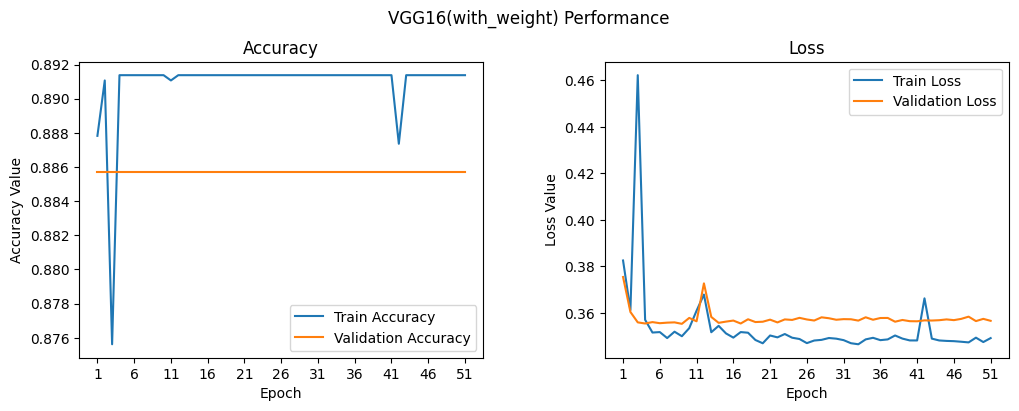

<Figure size 640x480 with 0 Axes>

In [63]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=50)

history = model.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    verbose=1,
                    epochs=epochs,
                    validation_data=(X_test, y_test),
                    shuffle=False,
                    callbacks=early_stopping
                    )


# model.save(modelpath+'/VGG3_WITHOUT_AUG.h5')


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('VGG16(with_weight) Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1, max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")


ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")
plt.show()

plt.savefig(figpath+'/VGG3(With_weights)_TRAIN_VS_VALIDATION_LOSS_WITHOUT_AUG.png',
            bbox_inches='tight')

In [64]:
print(X_test.shape)

(1619, 224, 224, 3)


In [65]:

# Instead of checking for each image, we can evaluate the model on all test data
# for accuracy
################################################################

# We can load the trained model, so we don't have to train again for 300 epochs!
from keras.models import load_model

_, acc = model.evaluate(X_test, y_test)
print("Test accuracy = ", (acc * 100.0), "%")

51/51 [==============================] - 1s 25ms/step - loss: 0.3567 - accuracy: 0.8857
Test accuracy =  88.57319355010986 %


51/51 [==============================] - 1s 23ms/step


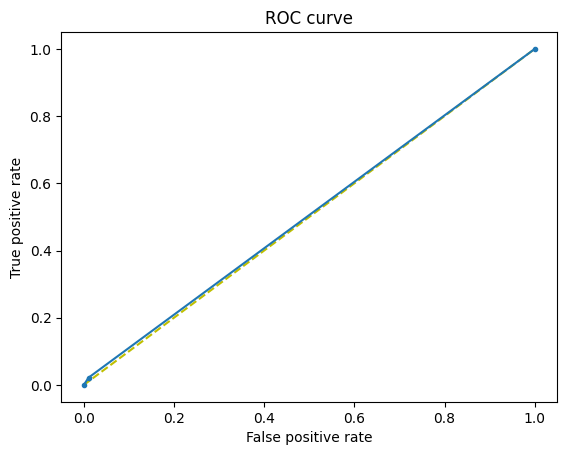

In [66]:
# How do we know how it is doing for AFFECTED vs NOT EFFECTED?
################################################################

# Confusion matrix
# We compare labels and plot them based on correct or wrong predictions.
# Since sigmoid outputs probabilities we need to apply threshold to convert to label.


# Check the confusion matrix for various thresholds. Which one is good?
# Need to balance positive, negative, false positive and false negative.
# ROC can help identify the right threshold.
##################################################################
"""
Receiver Operating Characteristic (ROC) Curve is a plot that helps us 
visualize the performance of a binary classifier when the threshold is varied. 
"""
# ROC
from sklearn.metrics import roc_curve
y_preds = model.predict(X_test).ravel()

fpr, tpr, thresholds = roc_curve(y_test, y_preds)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.savefig(figpath+'/VGG3(with weights)_ROC_CURVE_WITH_AUG.png', bbox_inches='tight')
plt.show()

In [67]:
"""
#One way to find the best threshold once we calculate the true positive 
and false positive rates is ...
The optimal cut off point would be where “true positive rate” is high 
and the “false positive rate” is low. 
Based on this logic let us find the threshold where tpr-(1-fpr) is zero (or close to 0)
"""
import pandas as pd
i = np.arange(len(tpr))
roc = pd.DataFrame({'tf': pd.Series(tpr-(1-fpr), index=i),
                   'thresholds': pd.Series(thresholds, index=i)})
# Locate the point where the value is close to 0
ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
print("Ideal threshold is: ", ideal_roc_thresh['thresholds'])

# Now use this threshold value in the confusion matrix to visualize the balance
# between tp, fp, fp, and fn

Ideal threshold is:  1    0.131286
Name: thresholds, dtype: float32


In [68]:
# AUC
# Area under the curve (AUC) for ROC plot can be used to understand how well a classifier
# is performing.
# % chance that the model can distinguish between positive and negative classes.

from sklearn.metrics import auc
auc_value = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value)

Area under curve, AUC =  0.5055806852877982


51/51 [==============================] - 1s 23ms/step
Confusion Matrix
 [[1434    0]
 [ 185    0]]
Average F1 Score per class: [0.93940387 0.        ]
Average_Macro F1 Score of the Model: 0.46970193252538484
Average_Weighted F1 score of the Model: 0.8320600015335415
Test Accuracy of the Model: 88.57319355010986%


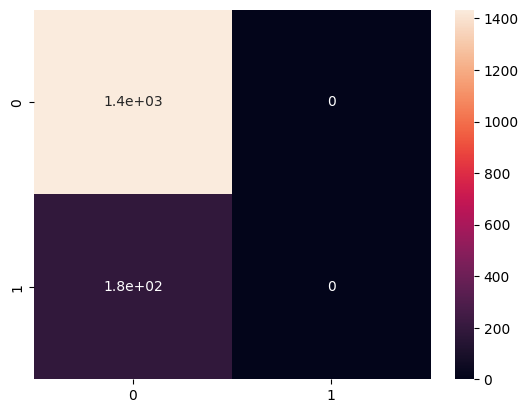

In [69]:
#########################################
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, classification_report
mythreshold = 0.131286

y_preds = (model.predict(X_test) >= mythreshold).astype(int)

cm = confusion_matrix(y_test, y_preds)
print('Confusion Matrix\n', cm)
hmp = sns.heatmap(cm, annot=True)
hmp_fig = hmp.get_figure()
hmp_fig.savefig(figpath+'/VGG16(with weights)_heatmap_WITHOUT_AUG.png', dpi=400)


f1scores_per_class = (f1_score(y_test, y_preds, average=None))
average_fscore_macro = (f1_score(y_test, y_preds, average="macro"))
average_fscore_weighted = (f1_score(y_test, y_preds, average="weighted"))
print('Average F1 Score per class:', f1scores_per_class)
print('Average_Macro F1 Score of the Model:', average_fscore_macro)
print('Average_Weighted F1 score of the Model:', average_fscore_weighted)
print(f'Test Accuracy of the Model: {acc * 100}%')

1/1 [==============================] - 0s 9ms/step


The prediction for this image is:  [[0]]
The actual label for this image is:  0  [1 = EFFECTED & 0= NOT EFFECTED]


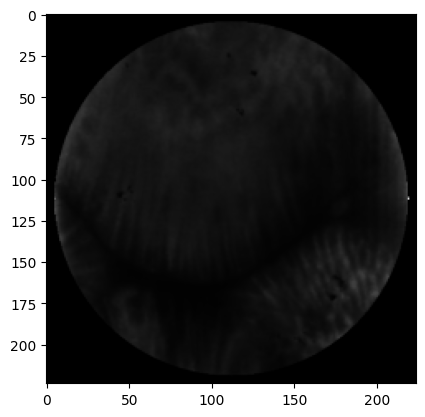

In [70]:
n = 102  # Select the index of image to be loaded for testing
img = X_test[n]
plt.imshow(img)
# Expand dims so the input is (num images, x, y, c)
input_img = np.expand_dims(img, axis=0)
print("The prediction for this image is: ",
      (model.predict(input_img) >= mythreshold).astype(int))
print("The actual label for this image is: ", y_test[n] , " [1 = EFFECTED & 0= NOT EFFECTED]")

In [53]:
import gc
del X_test, X_train, y_test, y_train
gc.collect()

8774